#### We're going to classify IMDB reviews by their sentiments

In [2]:
import keras
from keras.datasets import imdb
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Flatten, Dropout
from keras.layers import Embedding
from keras.callbacks import ModelCheckpoint
import os
from sklearn.metrics import roc_auc_score
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

C:\Amrendra\Anaconda\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [3]:
output_dr = 'model_output/dense'
epochs = 4
batch_size = 128

n_dim = 64 # Number of dimentions in vector space
n_unique_words = 5000
n_words_to_skip = 50  # skip top 50 most frequent words
max_review_length = 100
pad_type = trunc_type = 'pre'

n_dense = 64 # Number of neurons in hidden layer
dropout = 0.5

#### Load data

In [4]:
(x_train, y_train), (x_val, y_val) = imdb.load_data(num_words=n_unique_words, skip_top=n_words_to_skip)

#### Restore words from index

In [6]:
word_index = keras.datasets.imdb.get_word_index()

In [7]:
word_index = {k : (v+3) for k, v in word_index.items()}

In [8]:
word_index['PAD']=0
word_index['START']=1
word_index['UNK']=2

In [9]:
word_index['PAD']

0

In [10]:
index_word = {v:k for k,v in word_index.items()}

In [11]:
x_train = pad_sequences(x_train, maxlen=max_review_length, padding = pad_type, truncating=trunc_type)
x_val= pad_sequences(x_val, maxlen=max_review_length, padding = pad_type, truncating=trunc_type)

In [15]:
x_train[2]

array([1301,    2, 1873,    2,   89,   78,    2,   66,    2,    2,  360,
          2,    2,   58,  316,  334,    2,    2, 1716,    2,  645,  662,
          2,  257,   85, 1200,    2, 1228, 2578,   83,   68, 3912,    2,
          2,  165, 1539,  278,    2,   69,    2,  780,    2,  106,    2,
          2, 1338,    2,    2,    2,    2,  215,    2,  610,    2,    2,
         87,  326,    2, 2300,    2,    2,    2,    2,  272,    2,   57,
          2,    2,    2,    2,    2,    2, 2307,   51,    2,  170,    2,
        595,  116,  595, 1352,    2,  191,   79,  638,   89,    2,    2,
          2,    2,  106,  607,  624,    2,  534,    2,  227,    2,  129,
        113])

In [9]:
# check if the length is same for all review after padding above.
for x in x_train[0:5]:
    print(len(x))

100
100
100
100
100


#### Design NN architecture

In [10]:
model = Sequential()
model.add(Embedding(n_unique_words, n_dim, input_length=max_review_length))
model.add(Flatten())
model.add(Dense(n_dense, activation='relu'))
model.add(Dropout(dropout))
model.add(Dense(1,activation='sigmoid'))

In [11]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 100, 64)           320000    
_________________________________________________________________
flatten_1 (Flatten)          (None, 6400)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                409664    
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 65        
Total params: 729,729
Trainable params: 729,729
Non-trainable params: 0
_________________________________________________________________


In [12]:
n_dim, n_unique_words, n_dim*n_unique_words

(64, 5000, 320000)

In [13]:
n_dim, max_review_length, n_dim*max_review_length

(64, 100, 6400)

In [14]:
n_dense, n_dim*max_review_length*n_dense + n_dense

(64, 409664)

In [15]:
output_dr

'model_output/dense'

#### Configure model

In [16]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [17]:
modelcheckpoint = ModelCheckpoint(filepath=output_dr+"/weights.{epoch:02d}.hdf5")

In [18]:
if not os.path.exists(output_dr):
    os.makedirs(output_dr)

In [19]:
modelcheckpoint.filepath

'model_output/dense/weights.{epoch:02d}.hdf5'

#### Train

In [20]:
model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, verbose=1, validation_data=(x_val,y_val), callbacks=[modelcheckpoint])

Train on 25000 samples, validate on 25000 samples
Epoch 1/4
25000/25000 [==============================] - 6s 255us/step - loss: 0.5578 - acc: 0.6896 - val_loss: 0.3583 - val_acc: 0.8417
Epoch 2/4
25000/25000 [==============================] - 6s 247us/step - loss: 0.2821 - acc: 0.8865 - val_loss: 0.3480 - val_acc: 0.8444
Epoch 3/4
25000/25000 [==============================] - 7s 284us/step - loss: 0.1153 - acc: 0.9645 - val_loss: 0.4241 - val_acc: 0.8341
Epoch 4/4
25000/25000 [==============================] - 7s 277us/step - loss: 0.0239 - acc: 0.9961 - val_loss: 0.5243 - val_acc: 0.8328


In [21]:
model.load_weights(output_dr+'/weights.01.hdf5')

In [22]:
y_hat = model.predict_proba(x_val)

In [24]:
y_hat[1]

array([0.89359075], dtype=float32)

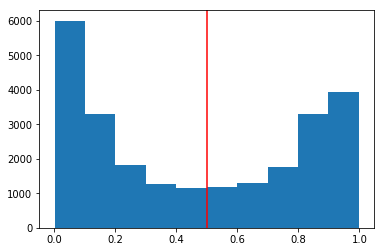

In [26]:
plt.hist(y_hat)
_= plt.axvline(x=0.5, color='red')

In [27]:
roc_auc_score(y_val,y_hat)*100

92.60323168

In [28]:
"{:0.2f}".format(roc_auc_score(y_val,y_hat)*100)

'92.60'

In [29]:
float_y_hat=[]
for y in y_hat:
    float_y_hat.append(y[0])

In [36]:
y_df= pd.DataFrame(list(zip(float_y_hat,y_val)), columns=['y_hat','y'])

In [37]:
y_df.head()

,y_hat,y
0,0.255617,0
1,0.893591,1
2,0.420744,1
3,0.245926,0
4,0.965060,1


In [55]:
' '.join(index_word[i] for i in x_val[2])

'UNK UNK UNK UNK UNK UNK civil war UNK would UNK easy UNK see UNK UNK UNK UNK UNK those events UNK may UNK may UNK UNK had UNK UNK UNK mind when UNK made UNK UNK whatever UNK UNK choice UNK material UNK UNK stands UNK UNK UNK tale UNK universal UNK UNK could UNK UNK soviet union italy germany UNK japan UNK UNK 1930s UNK any country UNK any era UNK lets its guard down UNK UNK UNK UNK UNK UNK UNK fascinating UNK even UNK charming UNK UNK its UNK way UNK its message UNK no joke'

In [53]:
x_val[0]

array([   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    2,
        591,  202,    2,    2,    2,  717,    2,    2,    2,    2,    2,
          2,  360,    2,    2,  177,    2,  394,  354,    2,  123,    2,
       1035, 1035, 1035,    2,    2,    2,   92,  124,   89,  488,    2,
        100,    2, 1668,    2,    2,    2,    2,    2,    2,  220,  468,
          2,  124,    2,  286,  170,    2,  157,    2,    2,    2,  239,
          2,  179,    2,    2,    2,    2,    2,  451,  202,    2,    2,
        717])